# Backtesting setup
I'm setting up infrastructure to backtest machine learning models. Initially, the models predict the price of certain markets, with the same model trained on all markets. Investment model is very simple based on the predictions. 

In [1]:
import quantiacsToolbox
from quantiacsToolbox import loadData
from quantiacs_ml import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, ensemble, metrics
%matplotlib inline

## Trading Strategy
This class is provided to quantiacstoolbox for testing. I use the mysettings() function in training the model, so that parameters remain consistent.

The way quantiacsToolbox.runts works:
* myTradingSystem is looped through for each day between beginInSample and endInSample
* Data fields (specified in the myTradingSystem call) on the relevant markets (specified in settings['markets']) is pulled. The number of historical days of data pulled is defined by settings['lookback'].
* The pos array defines which markets are owned at the end of each trading day. (TODO: Automatically normalized?)

In [2]:
class myStrategy(object):

    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):

        # Feature Generation for a single day
        # Generate Returns
        RETURNS = generate_returns(CLOSE,RINFO)

        # Generate Lag features
        lag_list = [1,2,3,5,10,25,50,100,150,200]
        LAG_LIST = lag_feats(RETURNS, lag_list, False)

        # Keep only the features for the last day
        X = np.array(LAG_LIST)[:,-1,:].T

        reg = settings['model']
        try:
            returns_pred = reg.predict(X)
            # Threshold
            returns_pred = (abs(returns_pred) > settings['threshold'])*returns_pred

            pos = np.sign(returns_pred)

        # for NaN data set position to 0
        except ValueError:
            # TODO: this isn't very robust
            print("trend isnan", np.isnan(trend).any())
            print("pos isnan", np.isnan(trend).any())
            pos[market] = .0

        return pos, settings
    
    def mySettings(self):
        """ Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD',
                               'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        # budget is the initial portfolio balance
        settings['budget'] = 10 ** 6

        # slippage simulates trading cost
        settings['slippage'] = 0.05

        # Return threshold. If the abs(ret) is below threshold, the system does not purchase/short the asset
        settings['threshold'] = 1e-5

        # Train, Val time ranges
        settings['train_start'] = '20100601'
        settings['train_end'] = '20120101'
        settings['val_start'] = '20120101'#settings['train_end']
        settings['val_end'] = '20140101'

        # The trading system uses beginInSample and endInSample. This is the test set.
        settings['beginInSample'] = settings['val_end']
        settings['endInSample'] = '20160101'
        
        # Lookback is how much historical data to pull for each day. Should exceed longest lag in features.
        settings['lookback'] = 200
        try:
            settings['model'] = MODEL
        except NameError:
            print("MODEL not provided, settings['model'] not set.")
            
        return settings

## Data Prep

In [3]:
# Load Settings
dataDir = "tickerData"
settings = myStrategy().mySettings()
dataToLoad = set(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'P', 'RINFO'])

# Train, Val
train_dict = loadData(marketList=settings['markets'], dataToLoad=dataToLoad, refresh=False, 
                    beginInSample=settings['train_start'], endInSample=settings['train_end'],
             dataDir="tickerData")
val_dict = loadData(marketList=settings['markets'], dataToLoad=dataToLoad, refresh=False, 
                    beginInSample=settings['val_start'], endInSample=settings['val_end'],
             dataDir=dataDir)

# Add RET to dictionaries
train_dict = generate_returns_dict(train_dict)
val_dict = generate_returns_dict(val_dict)

MODEL not provided, settings['model'] not set.
Loading Data...
Done!
Loading Data...
Done!


## Feature Generation
I don't have a great feature template yet. The issue is that, whatever features are created during training need to be replicable within myTradingSystem for a single day. At the moment, I'm using the same lag functions in both cases and only using the last row (i.e. the current day) within myTradingSystem.

In [4]:
# Generate lag features
lag_list = [1,2,3,5,10,25,50,100,150,200]
train_dict['LAG_LIST'] = lag_list
val_dict['LAG_LIST'] = lag_list

train_dict['LAG_FEATURES'] = lag_feats(train_dict['RET'], lag_list, False)
val_dict['LAG_FEATURES'] = lag_feats(val_dict['RET'], lag_list, False)

In [5]:
# Extract X and y from dictionaries
X_train, y_train = shape_lag_features(train_dict)
X_val, y_val = shape_lag_features(val_dict)

## Train Models
Two things to keep in mind here:
* These models are shaped to predict the current day's return for any market. Note that different models could be trained for each market, or sets of markets, or whatever is desired.
* These models are only predicting returns, they are not a full trading strategy. For now, I layer a very simnple trading strategy on top: buy all markets with return > threshold and short all markets with return < -threshold. All equal proportions.  More complex strategies can be utilized, but that question is separate from the return prediction models.

In [6]:
# Define and fit the model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

# Different model
reg2 = ensemble.RandomForestRegressor()
reg2.fit(X_train,y_train)

RandomForestRegressor()

In [7]:
# Dictionary of metrics to calculate
metric_dict = {"r2": metrics.r2_score,
               "MSE": metrics.mean_squared_error,
               "Accuracy": metrics.accuracy_score}

# List of metrics that operate on sign(y_pred)
binary_list = ['Accuracy']

# Calculate metrics for list of models
for model in [reg,reg2]:
    try:
        # If metric_df was already created, add to it
        metric_df = eval_model(reg2, X_train, X_val, y_train, y_val, 
               metric_dict, binary_list, metric_df)
    except NameError:
        # If metric_df does not exist, create it
        metric_df = eval_model(reg, X_train, X_val, y_train, y_val, 
               metric_dict, binary_list)

In [8]:
from tabulate import tabulate
pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')
print(pdtabulate(metric_df))

+----------------+-------------------+-------------------+
|                |   LinearRegressio |   RandomForestReg |
|----------------+-------------------+-------------------|
| r2_train       |       0.00865286  |       0.867681    |
| MSE_train      |       0.000251924 |       3.36254e-05 |
| Accuracy_train |       0.481306    |       0.918378    |
| r2_val         |      -0.0142065   |      -0.0735431   |
| MSE_val        |       0.000117629 |       0.000124511 |
| Accuracy_val   |       0.450511    |       0.484797    |
+----------------+-------------------+-------------------+


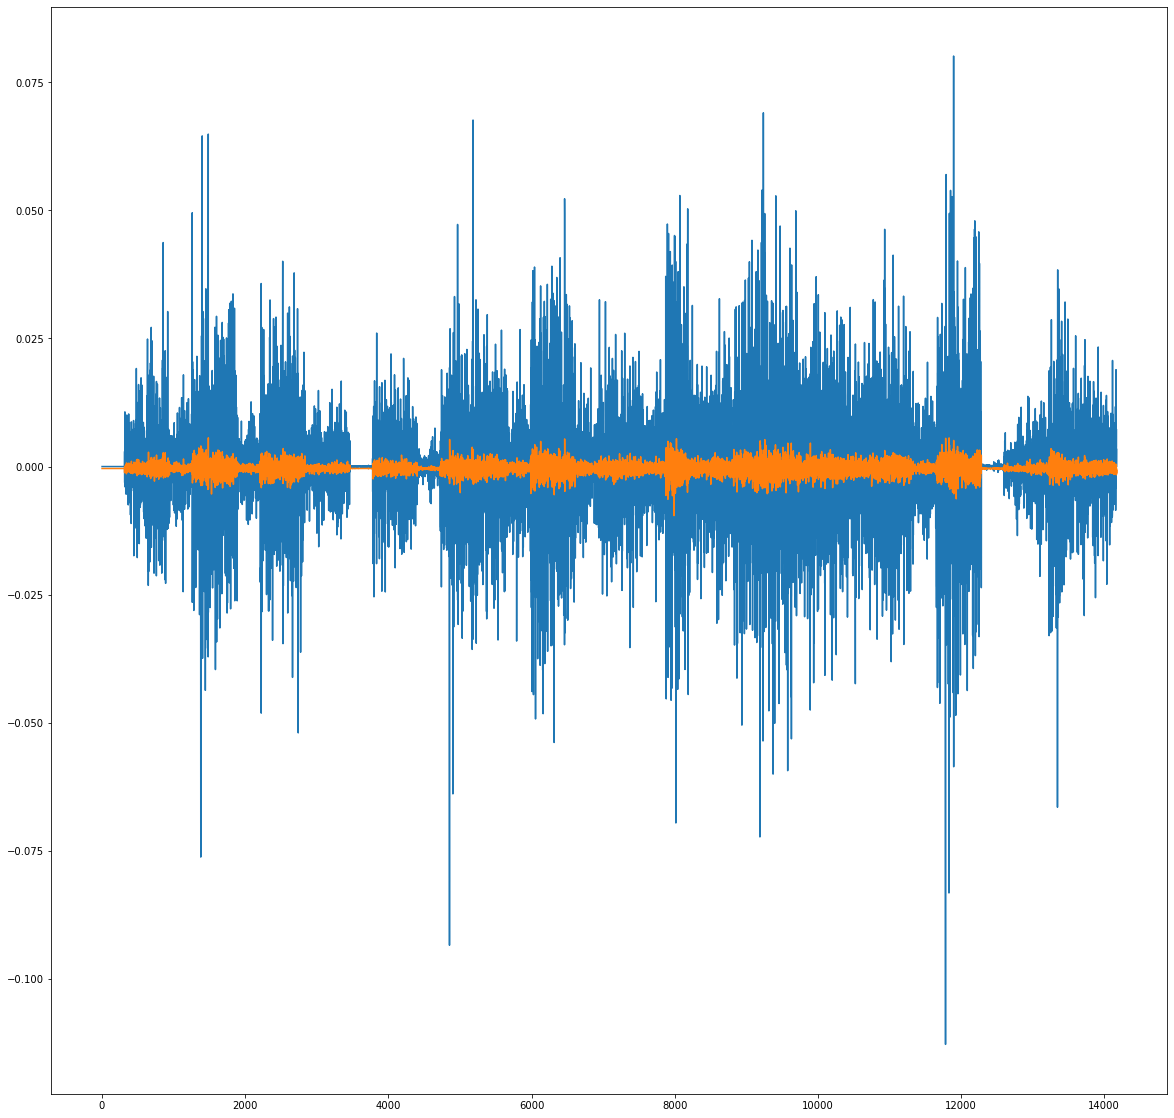

In [9]:
plt.figure(figsize=[20,20])
plt.plot(y_val)
y_val_pred = reg.predict(X_val)
plt.plot(y_val_pred)

In [10]:
# Define which model to test below
MODEL = reg2

## Trading strategy
Currently, the trading strategy is incredibly simple:
* Buy all markets with return > threshold 
* Short all markets with return < -threshold. 
* All equal proportions.
* Updated daily.

More complex strategies can be utilized, but that question is separate from the return prediction models.

TODO: To test more complex trading strategies, we need a train/validation setup for trading strategies before running them on the test set, to avoid overfitting.

Loading Data...
Done!
Evaluating Trading System <class '__main__.myStrategy'>


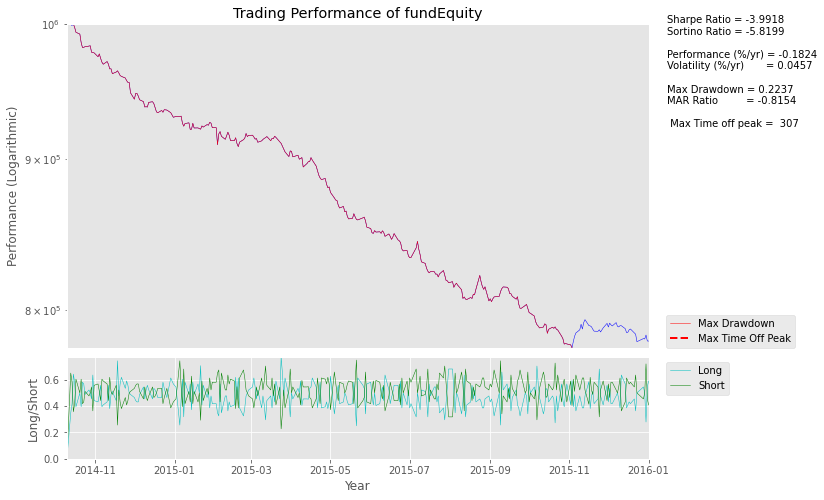

In [14]:
with np.errstate(invalid='ignore', divide='ignore'):
    result = quantiacsToolbox.runts(myStrategy,plotEquity=True)